Simple Audio Synthesis
======================

by Roger Allen

Over Thanksgiving break 2016, I was working with my son to create music via Python programming.  I found Jupyter notebooks to be quite useful for this purpose.  You can interactively create & listen to audio waveforms within the environment.  You can graph and zoom into waveforms to see what they look like.  The experiments below show how you can create complex waveforms by summing sine waves.  It is all "unfinished doodling", but might be fun for others.

In [1]:
%matplotlib inline
import IPython.display as ipd
import math
import matplotlib.pyplot as plt
import numpy as np
import scipy.signal as signal

In [2]:
# how many audio samples per second are in your waveforms.  44.1kHz is a standard value and allows 
# for 22.05kHz maximum frequency in your created audio.
SAMPLE_RATE   = 44100
# how many sine-wave overtones are summed to create saw, triangle & square waves
NUM_OVERTONES = 40
# indexes for the stereo waveform arrays
LEFT          = 0
RIGHT         = 1

In [3]:
# See http://www.syntorial.com/ for various ideas on expanding this
def simple_synth(sound_fn, freq, duration, 
                 env_times, env_amps, 
                 filter_freqs, filter_amps):
    """return a stereo numpy array of samples using sound_fn() at freq (in Hz) for duratation seconds.
    Optionally, describe an envelope of matching times (in seconds) and amplitudes (0-1) with matching arrays.
    Optionally, describe a filter with frequencies (in Hz) and amplitudes (0-1) with another set of matching arrays."""
    num_samples    = math.floor(SAMPLE_RATE * duration)
    samples        = np.zeros((2,num_samples))
    sample_times   = np.linspace(0.0, duration, num_samples)
    # synthesis --------------------------------------------
    samples[LEFT]  = sound_fn(freq,sample_times,LEFT)
    samples[RIGHT] = sound_fn(freq,sample_times,RIGHT)
    # envelope ---------------------------------------------
    if len(env_times) > 0:
        total = 0
        for i in range(len(env_times)-1):
            count = math.floor(SAMPLE_RATE * (env_times[i+1] - env_times[i]))
            if i == len(env_times)-2:
                count = num_samples - total
            total += count
            if i == 0:
                envelope_samples = np.linspace(env_amps[i], env_amps[i+1], count)
            else:
                envelope_samples = np.concatenate((envelope_samples, np.linspace(env_amps[i], env_amps[i+1], count)))
        samples[LEFT]  *= envelope_samples
        samples[RIGHT] *= envelope_samples
    # filter ------------------------------------------------
    if len(filter_freqs) > 0:
        filter_taps = signal.firwin2(151, filter_freqs, filter_amps, nyq=SAMPLE_RATE/2)
        # http://dsp.stackexchange.com/questions/19084/applying-filter-in-scipy-signal-use-lfilter-or-filtfilt
        samples[LEFT] = signal.filtfilt(filter_taps, 1.0, samples[LEFT])
        samples[RIGHT] = signal.filtfilt(filter_taps, 1.0, samples[RIGHT])
    return samples

In [4]:
# A basic set of functions to use with SimpleSynth: sine, square, saw and triangle waves.
def sine_wave(freq, ts, side):
    freq = freq+side*0.5
    return np.sin(ts*freq*2*math.pi)

def square_wave(freq, ts, side):
    #freq = freq+side*0.5
    for i in range(NUM_OVERTONES):
        k = 2*i + 1
        if i == 0:
            ys = np.sin(k*ts*freq*2*math.pi)/k
        else:
            ys += np.sin(k*ts*freq*2*math.pi)/k
    return ys*(4/np.pi)

def saw_wave(freq, ts, side):
    #freq = freq+side*0.5
    for i in range(1,NUM_OVERTONES):
        sgn = (-1)**(i-1)
        if i == 1:
            ys = sgn*np.sin(i*ts*freq*2*math.pi)/i
        else:
            ys += sgn*np.sin(i*ts*freq*2*math.pi)/i
    return ys*(2.0/np.pi)

def saw1_wave(freq, ts, side):
    return -1*saw_wave(freq, ts, side)

def triangle_wave(freq, ts, side):
    #freq = freq+side*0.5
    for i in range(NUM_OVERTONES):
        k = 2*i + 1
        sgn = (-1)**i
        if i == 0:
            ys = sgn*np.sin(k*ts*freq*2*math.pi)/(k*k)
        else:
            ys += sgn*np.sin(k*ts*freq*2*math.pi)/(k*k)
    return ys*8/(np.pi*np.pi)

(0, 250)

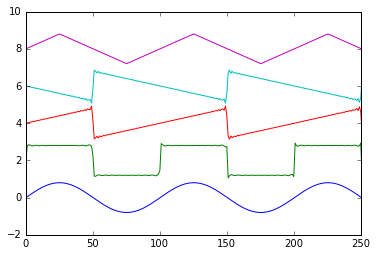

In [5]:
# plot the basic waveforms
plt.plot(0.8*simple_synth(sine_wave, 440, 1.0, [], [], [], [])[LEFT])
plt.plot(2+0.8*simple_synth(square_wave, 440, 1.0, [], [], [], [])[LEFT])
plt.plot(4+0.8*simple_synth(saw_wave, 440, 1.0, [], [], [], [])[LEFT])
plt.plot(6+0.8*simple_synth(saw1_wave, 440, 1.0, [], [], [], [])[LEFT])
plt.plot(8+0.8*simple_synth(triangle_wave, 440, 1.0, [], [], [], [])[LEFT])
plt.xlim(0,250)

In [6]:
# basic usage of 440Hz 1 second saw with an envelope and low-pass filter
# NOTE: Makes noise!
ipd.Audio(simple_synth(saw_wave, 440, 1.0, 
                       [0.0, 0.1, 0.9, 1.0], [0.0, 1.0, 1.0, 0.0],
                       [0, 1800, 2000, SAMPLE_RATE/2], [1.0, 1.0, 0.15, 0.0]),
           rate=SAMPLE_RATE,autoplay=True)

In [7]:
# Example effects to adjust the waveform.
def pan2(samples, position):
    """From Supercollider doc: Two channel equal power panner. Pan2 takes the square root of the linear scaling 
    factor going from 1 (left or right) to 0.5.sqrt (~=0.707) in the center, which is about 3dB reduction.  Avoids 
    problem inherent to linear panning is that the perceived volume of the signal drops in the middle"""
    samples[LEFT]  *= math.sqrt((1 - position)/2)
    samples[RIGHT] *= math.sqrt((position + 1)/2)
    return samples

def echo(samples, delay, amp, count):
    """Another example effect--echo the waveform given a delay (in seconds) an amplitude to decrease 
    the sound over time and an echo count."""
    num_samples = len(samples[LEFT]) + math.floor(delay*count*SAMPLE_RATE)
    new_samples = np.zeros((2,num_samples))
    new_samples[LEFT][:len(samples[LEFT])] = samples[LEFT]
    new_samples[RIGHT][:len(samples[RIGHT])] = samples[RIGHT]
    cur_amp = amp
    for i in range(count):
        start_sample_index = math.floor(delay*(i+1)*SAMPLE_RATE)
        end_sample_index = start_sample_index + len(samples[LEFT])
        new_samples[LEFT][start_sample_index:end_sample_index] += cur_amp*samples[LEFT]
        new_samples[RIGHT][start_sample_index:end_sample_index] += cur_amp*samples[RIGHT]
        cur_amp *= amp
    return new_samples


In [8]:
# test the Pan2
ipd.Audio(pan2(simple_synth(saw_wave, 440, 1.0, [], [], [], []),-0.75),rate=SAMPLE_RATE,autoplay=False)

In [9]:
# test the echo
ipd.Audio(echo(simple_synth(saw_wave, 440, 1.0, [0.0, 0.05, 0.5, 1.0], [0.0, 0.75, 0.75, 0.0], [], []),
               0.6, 0.6, 6),
          rate=SAMPLE_RATE,autoplay=False)

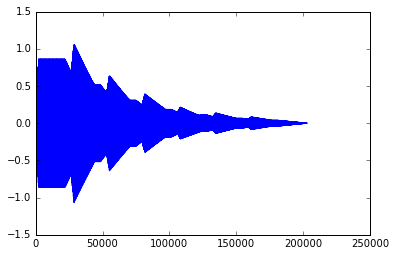

In [10]:
# see the echo
plt.plot(echo(simple_synth(saw_wave, 440, 1.0, [0.0, 0.05, 0.5, 1.0], [0.0, 0.75, 0.75, 0.0], [], []),
               0.6, 0.6, 6)[LEFT])

Saving Audio to Files
=====================

As part of the audio-creating excercise, I wanted to teach about how files with audio samples are stored.  That led to the following functions to write audio data as a WAV file.  This is just for pedagogical purposes to learn what is inside an audio file.  This is based on info at http://soundfile.sapp.org/doc/WaveFormat/ and you should read that page to understand the details of the audio header.

In [11]:
# we use the struct package to pack bytes for writing to a binary output file
import struct

# hard-coded values for simplicity
BITS_PER_SAMPLE = 16
BYTES_PER_SAMPLE = 2

def write_wav_file(filename,data):
    """open & write sound data to filename.  
    data is expected to be a numpy array with a shape of (1, NumSamples) or (2, NumSamples)"""
    if ((len(data.shape) != 2) or (not (0 < data.shape[0] <= 2))):
        print("data is expected to be a numpy array with a shape of (1, NumSamples) or (2, NumSamples)")
        return
    for i in range(data.shape[0]):
        if np.max(np.abs(data[i])) > 1.0:
            print("data[%d] is too loud.  Constrain to [-1.0,1.0]"%(i))
            return
    with open(filename,'wb') as f:
        write_wav_data(f,data)

def write_wav_data(wfile,data):
    write_wav_header(wfile,data)
    write_wav_audio(wfile,data)
    
def write_wav_header(wfile,data):
    """see http://soundfile.sapp.org/doc/WaveFormat/ for details"""
    NumChannels   = data.shape[0]
    NumSamples    = data.shape[1]
    Subchunk1Size = 16
    Subchunk2Size = NumSamples * NumChannels * BYTES_PER_SAMPLE
    ChunkSize     = 4 + (8 + Subchunk1Size) + (8 + Subchunk2Size)
    ByteRate      = SAMPLE_RATE * NumChannels * BYTES_PER_SAMPLE
    BlockAlign    = NumChannels * BYTES_PER_SAMPLE
    wfile.write(struct.pack('>I',0x52494646))      # 4 ChunkID "RIFF"
    wfile.write(struct.pack('<I',ChunkSize))       # 4 ChunkSize
    wfile.write(struct.pack('>I',0x57415645))      # 4 Format "WAVE"
    wfile.write(struct.pack('>I',0x666d7420))      # 4 Subchunk1ID "fmt "
    wfile.write(struct.pack('<I',Subchunk1Size))   # 4 Subchunk1Size
    wfile.write(struct.pack('<H',1))               # 2 AudioFormat (1=linear)
    wfile.write(struct.pack('<H',NumChannels))     # 2 NumChannels
    wfile.write(struct.pack('<I',SAMPLE_RATE))     # 4 SampleRate
    wfile.write(struct.pack('<I',ByteRate))        # 4 ByteRate
    wfile.write(struct.pack('<H',BlockAlign))      # 2 BlockAlign
    wfile.write(struct.pack('<H',BITS_PER_SAMPLE)) # 2 BitsPerSample
    wfile.write(struct.pack('>I',0x64617461))      # 4 Subchunk2ID "data"
    wfile.write(struct.pack('<I',Subchunk2Size))   # 4 Subchunk2Size

def write_wav_audio(wfile,data):
    NumChannels   = data.shape[0]
    NumSamples    = data.shape[1]
    # 16-bit samples are stored as 2's-complement signed integers, ranging from -32768 to 32767.
    for i in range(NumSamples):
        wfile.write(struct.pack('<h',math.floor(32767*data[0][i])))
        if NumChannels > 1:
            wfile.write(struct.pack('<h',math.floor(32767*data[0][i])))

In [12]:
# (had to reduce the volume just a bit to fit in -1,1)
samples = echo(simple_synth(saw_wave, 440, 1.0, [0.0, 0.05, 0.5, 1.0], [0.0, 0.6, 0.6, 0.0], [], []),
               0.6, 0.6, 6)
write_wav_file("saw_echo.wav", samples)